In [1]:
import sys
sys.path.append("../library")

In [2]:
from __future__ import print_function
from thinkbayes2 import Suite, Pmf, Cdf
import thinkplot

In [3]:
# perfectly balanced coin, refer to https://github.com/AllenDowney/ThinkBayes2/blob/master/code/euro.py
class Euro(Suite):
    def Likelihood(self, data, hypo):
        x = hypo
        if data == 'H':
            return x / 100.0
        else:
            return 1 - x / 100.0

In [4]:
def Summarize(suite):
    """
    Prints summary statistics for the suite.
    """
    # check if 50% probablity of balanced coin
    print(suite.Prob(50))
    # 1. Maximum Likelihood
    print('Maximum Likelihood: ', suite.MaximumLikelihood())
    # 2. Mean and Median
    print('Mean: ', suite.Mean())
    print('Median: ', suite.Percentile(50)) 
    print('5th: ', suite.Percentile(5)) 
    print('95th: ', suite.Percentile(95)) 
    # 3. Credible inverval
    print('Credible inveral', suite.CredibleInterval(90))

In [5]:
Hx = 101
suite = Euro(range(Hx))
dataset = 'H' * 140 + 'T' * 110
suite.UpdateSet(dataset)
Summarize(suite)
# if not include 50, then coin isn't perfectly balanced

0.020976526129544672
Maximum Likelihood:  56
Mean:  55.95238095238098
Median:  56
5th:  51
95th:  61
Credible inveral (51, 61)


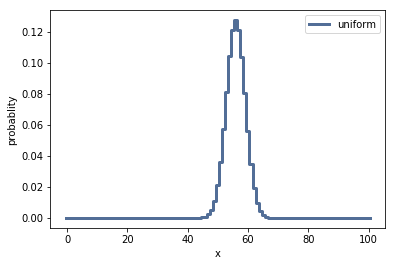

In [6]:
thinkplot.PrePlot(1)
thinkplot.Pmf(suite, label='uniform')
thinkplot.Show(xlabel='x', ylabel='probablity')

In [7]:
# replace prior with triangle prior
# perfectly balanced coin, refer to https://github.com/AllenDowney/ThinkBayes2/blob/master/code/euro.py
class Euro1(Suite):
    def __init__(self, hypos):
        super().__init__(self)
        for x in range(0, 51):
            self.Set(x, x)
        for x in range(51, 101):
            self.Set(x, 100 - x)
        self.Normalize()
        
    def Likelihood(self, data, hypo):
        x = hypo
        if data == 'H':
            return x / 100.0
        else:
            return 1 - x / 100.0

In [8]:
Hx = 101
suite = Euro1(range(Hx))
dataset = 'H' * 140 + 'T' * 110
suite.UpdateSet(dataset)
Summarize(suite)

0.02384753721469363
Maximum Likelihood:  56
Mean:  55.74349943859506
Median:  56
5th:  51
95th:  61
Credible inveral (51, 61)


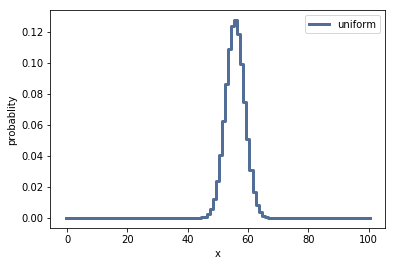

In [9]:
thinkplot.PrePlot(1)
thinkplot.Pmf(suite, label='uniform')
thinkplot.Show(xlabel='x', ylabel='probablity')

In [10]:
# replace prior with triangle prior
# perfectly balanced coin, refer to https://github.com/AllenDowney/ThinkBayes2/blob/master/code/euro.py
# optimize with group power() function, instead of looping for each case of head, tail
class Euro2(Suite):
    def __init__(self, hypos):
        super().__init__(self)
        for x in range(0, 51):
            self.Set(x, x)
        for x in range(51, 101):
            self.Set(x, 100 - x)
        self.Normalize()
        
    def Likelihood(self, data, hypo):
        """
        replace data with (heads, tails)
        """
        x = hypo / 100.0
        heads, tails = data
        like = x ** heads * (1-x) ** tails
        return like

In [11]:
Hx = 101
suite = Euro2(range(Hx))
heads, tails = 140, 100
suite.Update((heads, tails))
Summarize(suite)

0.005292169225214459
Maximum Likelihood:  58
Mean:  58.02692703565193
Median:  58
5th:  53
95th:  63
Credible inveral (53, 63)


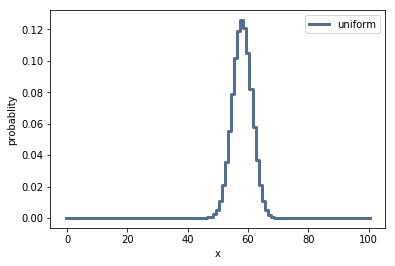

In [12]:
thinkplot.PrePlot(1)
thinkplot.Pmf(suite, label='uniform')
thinkplot.Show(xlabel='x', ylabel='probablity')

In [13]:
# using beta distribution
from thinkbayes2 import Beta

In [14]:
beta = Beta()
beta.Update((140, 100))
print("Mean for beta distribution: {}".format(beta.Mean()))
pmfBeta = beta.MakePmf()
print("Probablity for 50% of beta distribution: {}".format(pmfBeta.Prob(50)))
cdfBeta = beta.MakeCdf()
print("Median for beta distribution: {}".format(cdfBeta.Percentile(50)))
print("Credible interval for beta distribution: {}".format(cdfBeta.ConfidenceInterval(90)))

Mean for beta distribution: 0.5826446280991735
Probablity for 50% of beta distribution: 0
Median for beta distribution: 0.59
Credible interval for beta distribution: (0.54000000000000004, 0.64000000000000001)


# Exercise 4.7: observation variable y

**Exercise** Suppose that instead of observing coin tosses directly, you measure the outcome using an instrument that is not always correct. Specifically, suppose there is a probability y that an actual heads is reported as tails, or actual tails reported as heads.

Write a class that estimates the bias of a coin given a series of outcomes and the value of y.

How does the spread of the posterior distribution depend on y?

In [15]:
# refer to https://github.com/AllenDowney/ThinkBayes2/blob/master/code/chap04soln.ipynb
class ObservableCoin(Suite):
    def __init__(self, prior, y):
        """
        prior: seq or map
        y: probability of accurate measurement
        """
        # super() with prior parameter, refer to https://stackoverflow.com/questions/576169/understanding-python-super-with-init-methods
        super().__init__(prior);
        # equivanlent to super().__init__(prior)
        # Suite.__init__(self, prior);
        self.y = y
        
    def Likelihood(self, data, hypo):
        """
        data: outcome of unreliable measurement, either 'H' or 'T'
        hypo: probability of heads, 0-100
        """
        x = hypo / 100
        y = self.y
        if data == 'H':
#             correctly report head and guarantee correctness, or report tail and happend to report incorrectly
            return x * y + (1-x) * (1-y)
        else:
#         report tail and guarantee correctness, or report head and happend to report incorrectly
            return (1-x) * y + x * (1-y)

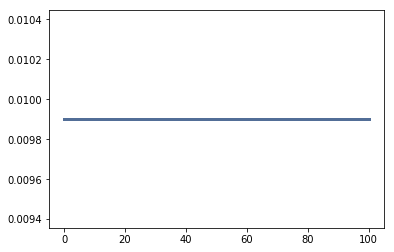

In [16]:
# Solution 1 : Now let's initialize one with `y=0.9`:
prior = range(0, 101)
suite = ObservableCoin(prior, y=0.9)
thinkplot.Pdf(suite)

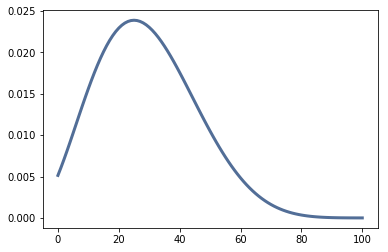

In [17]:
# Solution 2 : And update with 3 heads and 7 tails.
for outcome in 'HHHTTTTTTT':
    suite.Update(outcome)
thinkplot.Pdf(suite)

In [18]:
# Solution 3 : Now let's try it out with different values of `y`:
def compute_prior(y, color: str = 'C0'):
    prior = range(0, 101)
    suite = ObservableCoin(prior, y=y)
    for outcome in 'HHHTTTTTTT':
        suite.Update(outcome)
    
    thinkplot.Pdf(suite, label='y=%g' % y, color=color)

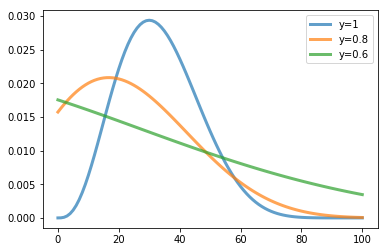

In [19]:
# The posterior distribution gets wider as the measurement gets less reliable.
compute_prior(1)
compute_prior(0.8, 'C1')
compute_prior(0.6, 'C2')
thinkplot.config(legend=True)

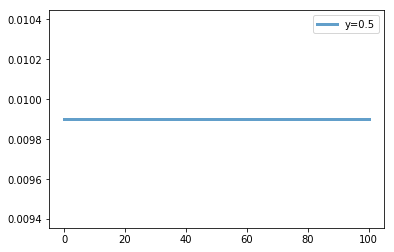

In [20]:
# Solution 4 : At `y=0.5`, the measurement provides no information, so the posterior equals the prior:
compute_prior(0.5)
thinkplot.config(legend=True)

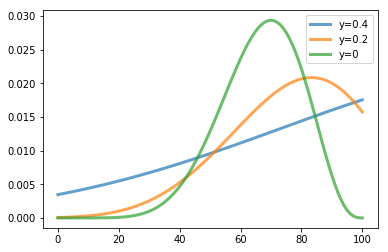

In [21]:
# Solution 5 : As the coin gets less reliable (below `y=0.5`) the distribution gets narrower again.  
# In fact, a measurement with `y=0` is just as good as one with `y=1`, 
# provided that we know what `y` is.
compute_prior(0.4)
compute_prior(0.2, 'C1')
compute_prior(0.0, 'C2')
thinkplot.config(legend=True)